In [1]:
from i308_calib import *
from i308_utils import *
import cv2
import pickle
import sys
import os
import matplotlib.pyplot as plt
# import stereodemo
import json
import numpy as np

sys.path.append(os.path.abspath(os.path.join("..", "src")))
from calib_funcs import *
from rect_funcs import *


%load_ext autoreload
%autoreload 2

## Budha

In [2]:
with open("../datasets/budha_board/calibration_results/stereo_calibration.pkl", "rb") as f:
    calibration_results = pickle.load(f)

In [3]:
with open("../datasets/budha_board/rectification_results/stereo_rectification.pkl", "rb") as f:
    rectification_results = pickle.load(f)

In [4]:
print(calibration_results.keys())
print(rectification_results.keys())

dict_keys(['left_K', 'left_dist', 'right_K', 'right_dist', 'R', 'T', 'E', 'F', 'image_size'])
dict_keys(['R1', 'R2', 'P1', 'P2', 'Q', 'validRoi1', 'validRoi2', 'left_map_x', 'left_map_y', 'right_map_x', 'right_map_y'])


In [5]:
# left_K = calibration_results["left_K"]
# right_K = calibration_results["right_K"]

# stereo_config = {
#     "width": calibration_results["image_size"][0],
#     "height": calibration_results["image_size"][1],
#     "fx": float(left_K[0][0]),
#     "fy": float(left_K[1][1]),
#     "cx0": float(left_K[0][2]),
#     "cx1": float(right_K[0][2]),
#     "cy": float(left_K[1][2]),
#     "baseline_meters": float(np.linalg.norm(calibration_results["T"])),
#     "depth_range": [0.5, 5]  # O ajusta esto según tu escenario
# }

# # Guardar en archivo JSON
# output_path = r"..\datasets\budha_board\stereodemo_calibration.json"
# with open(output_path, "w") as f:
#     json.dump(stereo_config, f, indent=4)

# print(f"Archivo JSON de configuración guardado en:\n{output_path}")

In [6]:
path = "../datasets/budha_board/rectified_captures"
left_images, right_images = get_images(path, prefix="", ext="jpg", print_info=True)
left_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in left_images]
right_gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in right_images]


Found 6 left images and 6 right images
First left image: ..\datasets\budha_board\rectified_captures\left_rectified_0.jpg
First right image: ..\datasets\budha_board\rectified_captures\right_rectified_0.jpg


In [7]:
#usamos en la terminal porque stereodemo no funca en una celda o un .py

# stereodemo.block_stereo_demo(
#     left_rectified_images,
#     right_rectified_images,
#     max_disparity=128,   # probá con 64 o 128 según tu escena
#     block_size=11,       # tamaño de bloque (impar, típicamente 5–21)
#     use_sgbm=True        # True = usa StereoSGBM
# )

Disparidad

Ahora que ya hicimos la calibración estéreo, podemos rectificar el par de imágenes estéreo de modo tal que las correspondencias izquierdas y derechas caigan perfectamente en la misma línea.

La disparidad es simplemente **la diferencia horizontal de dos puntos correspondientes (en la misma coordenada y)**

¿cómo hacemos para encontrar las correspondencias?

Podríamos intentar comparar los valores de gris de los píxeles en la misma fila del par de imágenes estéreo. 

Este método no es muy robusto. Por ejemplo, píxeles que no son correspondientes en las diferentes imágenes pueden tener la misma intensidad. Por otro lado,
para correspondencias buenas, los valores de gris en las cámaras distintas puede no coincidir.


## Block Matching

El algoritmo de Block Matching es uno de los métodos más comunes para calcular disparidad dada un par de imágenes estéreo rectificado.

¿Cómo funciona Block Matching?

1. Búsqueda de bloques:
El algoritmo se basa en dividir la imagen en pequeñas ventanas o bloques de píxeles. Se toma un bloque centrado en un píxel de la imagen izquierda y se busca el bloque correspondiente en la imagen derecha. El objetivo es encontrar el bloque en la imagen derecha que sea lo más similar posible al bloque de la imagen izquierda. La diferencia en la posición horizontal entre los bloques es la disparidad.

2. Ventana de búsqueda (disparidad máxima):
La búsqueda no se realiza en toda la imagen derecha, sino dentro de una ventana de búsqueda horizontal limitada. Esto se debe a que los objetos cercanos tienen grandes diferencias de posición entre las dos imágenes, mientras que los objetos lejanos tienen pequeñas diferencias. Por lo tanto, solo se busca dentro de un rango limitado de posiciones de disparidad, lo que reduce el tiempo de cálculo y el riesgo de errores.

3. Medición de similitud:
Para decidir cuál es el bloque de la imagen derecha más similar al bloque de la imagen izquierda, el algoritmo utiliza una función de similitud o costo. Las funciones de similitud más comunes son:

- SSD (Sum of Squared Differences): Suma de las diferencias cuadradas de los valores de píxeles entre los bloques.

	$ SSD = \sum_{i,j} (I_{izq}(x+i, y+j) - I_{der}(x+i-d, y+j))^2 $

	en donde d es la disparidad.

- SAD (Sum of Absolute Differences): Suma de las diferencias absolutas entre los valores de los píxeles en los bloques.
- NCC (Normalized Cross-Correlation): Otra métrica más robusta que mide la correlación entre bloques.


4. Selección de la disparidad:
Para calcular la disparidad, el algoritmo prueba múltiples valores de $d$ y calcula la SSD (o la métrica elegida) para cada uno. La disparidad para un píxel se determina eligiendo el valor de d que minimiza la SSD (es decir, donde los bloques de las dos imágenes coinciden mejor).
 
6. Repetición para cada píxel:
El proceso se repite para cada píxel de la imagen izquierda, generando un mapa de disparidad denso, que contiene la disparidad calculada para cada píxel de la imagen. Se puede utilizar programación dinámica o imágenes integrales para acelerar este paso.


## Block Matching con OpenCV

OpenCV define una familia de algoritmos de disparidad [StereoMatcher](https://docs.opencv.org/4.10.0/d2/d6e/classcv_1_1StereoMatcher.html).
La implementación de [BlockMatching](https://docs.opencv.org/4.10.0/d9/dba/classcv_1_1StereoBM.html) extiende dicha interface base.

### Parámetros de Block Matching:

- **numDisparities:** es el número máximo de disparidades (desplazamientos) a probar. Debe ser un múltiplo de 16. Valores mayores permiten detectar objetos a mayores distancias (más lejos de las cámaras), pero incrementa el tiempo de cálculo. Si nos interesan objetos más cercanos, podemos probar con valores menores.

- **blockSize:** Define el tamaño del bloque de píxeles que el algoritmo utiliza para comparar las dos imágenes. Valores mayores hace que las áreas homogéneas (con pocas texturas) se procesen mejor, pero puede perder detalles finos y aumenta el tiempo de cálculo. Valores menores funcionan mejor si queremos más detalles, pero nos introduce más ruido.

- **preFilterSize:** Define el tamaño del filtro que se aplica antes de la comparación de bloques para reducir el ruido en las imágenes. El valor debe ser impar y estar entre 5 y 255. Valores mas grandes reducen más el ruido, pero pueden eliminar detalles. Menores valores mantienen más detalles, pero es más sensible al ruido.

- **preFilterCap:** Limita (clipea) los valores filtrados para mejorar la robustez del algoritmo. Los valores de píxel filtrados se limitan entre -preFilterCap y preFilterCap. Entre 1 y 31.

- **minDisparity:** Establece el valor mínimo de disparidad. En la mayoría de los casos, se usa 0, pero si se sabe que algunos objetos en la escena tienen disparidades negativas, se puede ajustar a un valor menor.

- **textureThreshold:** Se utiliza para ignorar áreas con muy poca textura. Si el contraste dentro de un bloque es menor que este umbral, el algoritmo asigna una disparidad de 0 (o ignora el bloque). Un valor mayor mejora la precisión en áreas con baja textura. Mayor valor, evita errores en áreas homogéneas, pero puede ignorar pequeños detalles.

- **uniquenessRatio:** Controla cuán único debe ser el bloque coincidente. Esto es útil para eliminar errores ambiguos en la correspondencia. Mayor valor, hace que la coincidencia sea más estricta, evitando falsas correspondencias, pero podría ignorar algunos puntos de la imagen. Menor valor, acepta más correspondencias, pero podría aumentar el ruido.

- **speckleWindowSize:** Elimina pequeñas regiones aisladas en el mapa de disparidad que probablemente son ruido. Define el tamaño máximo de una región de píxeles conectados que pueden ser considerados como ruido y eliminados. Mayor valor, Filtra más ruido, pero podría eliminar detalles finos. Menor valor, mantiene más detalles, pero podría dejar más ruido.

- **speckleRange:** Define la diferencia máxima de disparidad entre píxeles conectados dentro de una región. Esto se usa junto con speckleWindowSize para determinar si una región debe ser eliminada.

- **disp12MaxDiff:** Controla la diferencia máxima permitida entre las disparidades calculadas para las imágenes izquierda y derecha (consistencia izquierda-derecha). Si la diferencia entre las disparidades excede este valor, se descarta la disparidad. Mayor valor, acepta más disparidades, pero puede introducir errores. Menor valor, hace que el algoritmo sea más estricto, eliminando más errores, pero podría perder algunos píxeles válidos.



Semi-Global Block Matching SGBM

StereoSGBM (Semi-Global Block Matching) es una variante mejorada del algoritmo de Block Matching tradicional (StereoBM). 
Pero es computacionalmente más caro.

Aunque ambos algoritmos calculan un mapa de disparidad entre imágenes estéreo, StereoSGBM introduce un enfoque de correspondencia semi-global, que mejora la precisión en áreas con poca textura y bordes suaves, donde el enfoque clásico de bloques de StereoBM falla. 

El enfoque semi-global, optimiza la disparidad no solo a nivel local, sino también considerando múltiples direcciones alrededor de cada píxel, lo que mejora la coherencia del mapa de disparidad.

1. Búsqueda de bloques: Es similar a BM, pero en lugar de tomar la mejor correspondencia inmediatamente, StereoSGBM sigue optimizando la solución considerando también la información global, asegurando la coherencia en la disparidad a lo largo de la imagen.
   
2. Función de costo, combina las métricas anteriores con una penalización de cambios bruscos de disparidad entre píxeles vecinos (costo suavizado).

### Parámetros adicionales:

- P1 y P2: Estos parámetros controlan la suavidad de las disparidades.  

  - P1: penaliza cambios pequeños de disparidad entre píxeles vecinos. Un valor mayor suaviza la transición entre píxeles.
  - P2: penaliza cambios bruscos de disparidad entre píxeles vecinos. Un valor mayor evita que las disparidades varíen mucho entre píxeles cercanos.

Generalmente, P2 debe ser mayor que P1.


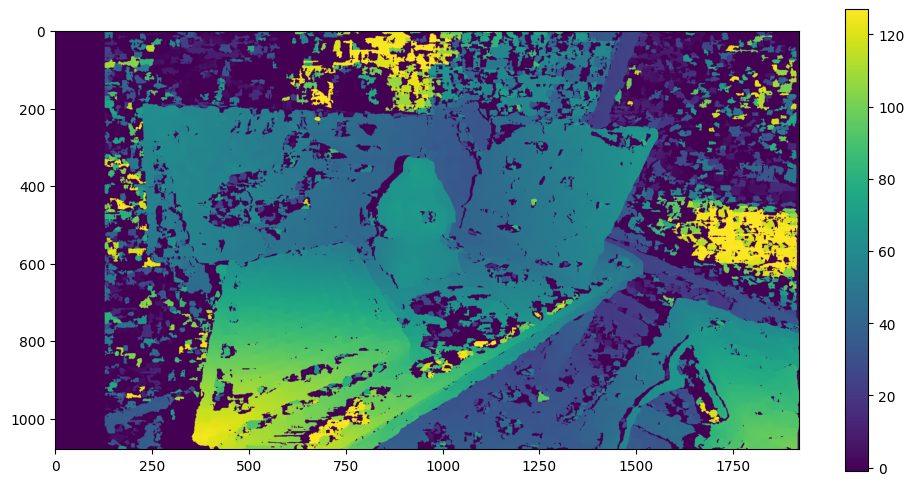

In [8]:
# stereo = cv2.StereoSGBM_create(
#     numDisparities=64,
#     blockSize=11
# )
idx= 0
# # stereo.setBlockSize(3)
# # stereo.setMode()

# stereo.setP1(16)
# stereo.setP2(128)
# stereo.setUniquenessRatio(7)
# stereo.setSpeckleWindowSize(512)
# stereo.setSpeckleRange(64)
# stereo.setDisp12MaxDiff(1)
# stereo.setPreFilterCap(63)
stereo = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,           # múltiplo de 16
    blockSize=19,                  # ventana chica para detalles
    P1=648,
    P2=1443,
    uniquenessRatio=4,
    speckleWindowSize=100,
    speckleRange=9,
    disp12MaxDiff=1,
    preFilterCap=11,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# Cálculo del mapa de disparidad
disparity_map = stereo.compute(
    left_gray_images[idx],
    right_gray_images[idx]
).astype(np.float32) / 16.0

plt.figure(figsize=(12, 6))
plt.imshow(disparity_map)
plt.colorbar()
plt.show()

In [9]:

from disparity.method_cre_stereo import CREStereo
from disparity.method_opencv_bm import StereoBM, StereoSGBM
from disparity.methods import Calibration, InputPair, Config

w, h = left_images[idx].shape[1], left_images[idx].shape[0]

left_K = calibration_results["left_K"]
fx = left_K[0][0]
fy = left_K[1][1]
cx0 = left_K[0][2]
cy0 = left_K[1][2]
T = calibration_results["T"]
baseline = np.linalg.norm(T)



calibration = Calibration(**{
    "width": w,
    "height": h,
    "baseline_meters": baseline / 1000,
    "fx": fx,
    "fy": fy,
    "cx0": cx0,
    "cx1": cx0,
    "cy": cy0,
    "depth_range": [0.05, 20.0],
    "left_image_rect_normalized": [0, 0, 1, 1]
})


In [10]:
import os
from pathlib import Path

models_path = "models"
if not os.path.exists(models_path):
    os.makedirs(models_path)

models_path = Path.home() / ".cache" / "stereodemo" / "models"
models_path = Path(models_path)

left_rgb = cv2.cvtColor(left_images[idx], cv2.COLOR_BGR2RGB)
right_rgb = cv2.cvtColor(right_images[idx], cv2.COLOR_BGR2RGB)
pair = InputPair(left_rgb, right_rgb, calibration)
# pair = InputPair(left_image, right_image, calibration)
config = Config(models_path=models_path)

# params = {
#    "Shape": "1280x720",
#    "Mode": "combined",
#    "Iterations": 20
#}
method = CREStereo(config)

#method.parameters["Shape"].set_value("640x480")
method.parameters["Shape"].set_value("1280x720")
# method.parameters["Iterations"].set_value("10")
method.parameters["Mode"].set_value("combined")
method.parameters["Iterations"].set_value("10")
#method.parameters.update(params)
# method = StereoBM(config)
# method = StereoSGBM(config)
# method = StereoBM(config)
disparity = method.compute_disparity(pair)

C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx


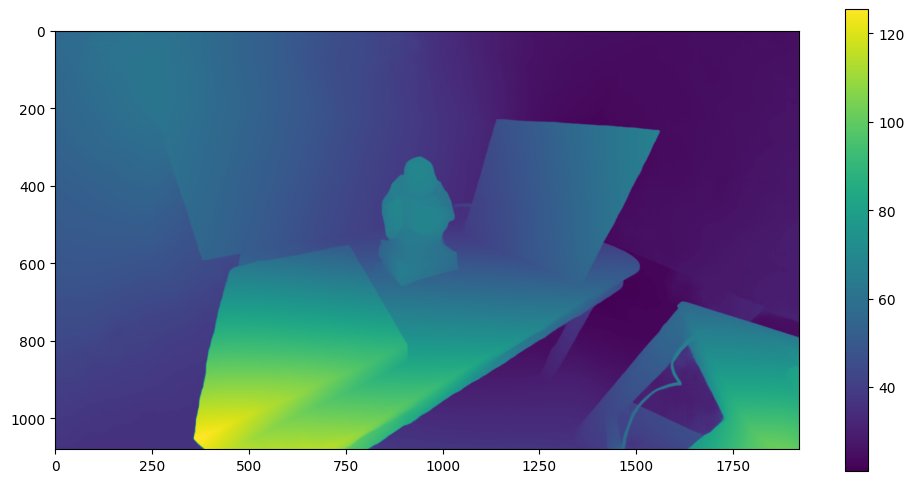

In [11]:
plt.figure(figsize=(12, 6))
plt.imshow(disparity.disparity_pixels)
plt.colorbar()
plt.show()

In [12]:
def compute_depth(disparity_map, f, B, default=1000.0):

    # Crea una copia del mapa de disparidad
    disparity_map = disparity_map.copy()
    
    # Evita divisiones por cero o disparidades negativas (les asignamos el valor default)
    mask_invalid = (disparity_map <= 0)
    
    # Calcula la profundidad con la fórmula Z = f * B / disparidad
    depth_map = np.zeros_like(disparity_map, dtype=np.float32)
    depth_map[~mask_invalid] = (f * B) / disparity_map[~mask_invalid]
    
    # Asigna valor fijo a los puntos donde la disparidad es inválida
    depth_map[mask_invalid] = default
    
    return depth_map

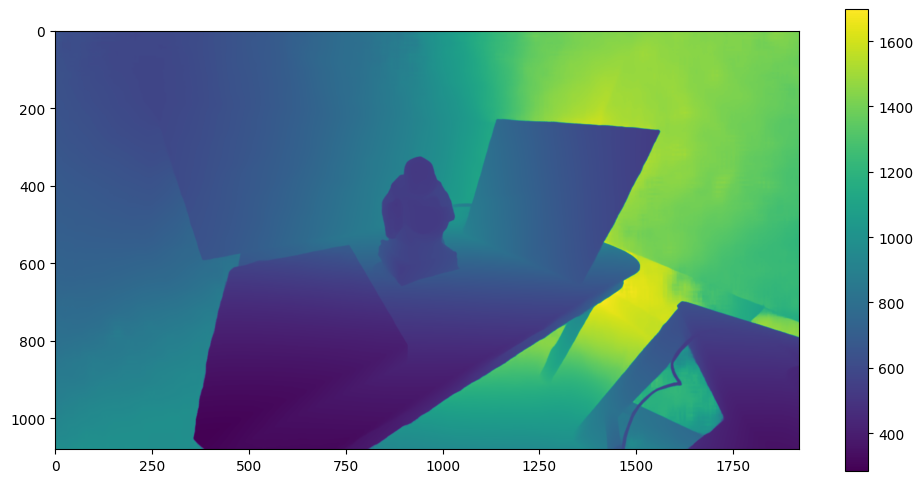

In [13]:
# disparity = np.load("disparity.npz")["arr_0"]
disparity_map = disparity.disparity_pixels

f = left_K[0][0]
B = np.linalg.norm(T) 

depth = compute_depth(disparity_map, f, B)

plt.figure(figsize=(12, 6))
plt.imshow(depth)
plt.colorbar()
plt.show()

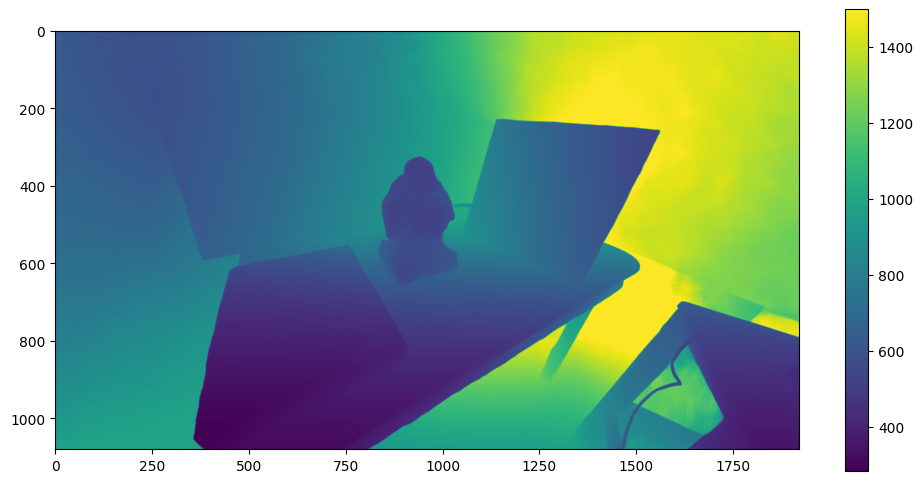

In [14]:
depth2 = depth.copy()
clip = 1500
depth2[depth2 > clip] = clip 
plt.figure(figsize=(12, 6))
plt.imshow(depth2)
plt.colorbar()
plt.show()

In [15]:
disparities = []

for i, (left_image, right_image) in enumerate(zip(left_images, right_images)):
    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
    pair = InputPair(left_image, right_image, calibration)
    disparity = method.compute_disparity(pair)
    disparities.append(disparity.disparity_pixels)

C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx
C:\Users\Lucio\.cache\stereodemo\models\crestereo_combined_iter10_720x1280.onnx


In [16]:
f = left_K[0][0]
B = baseline = np.linalg.norm(T) 
depths = []
for i, disparity in enumerate(disparities):
    depth = compute_depth(disparity, f, B)
    depths.append(depth)



# depth = compute_depth(disparity_map, f, B)

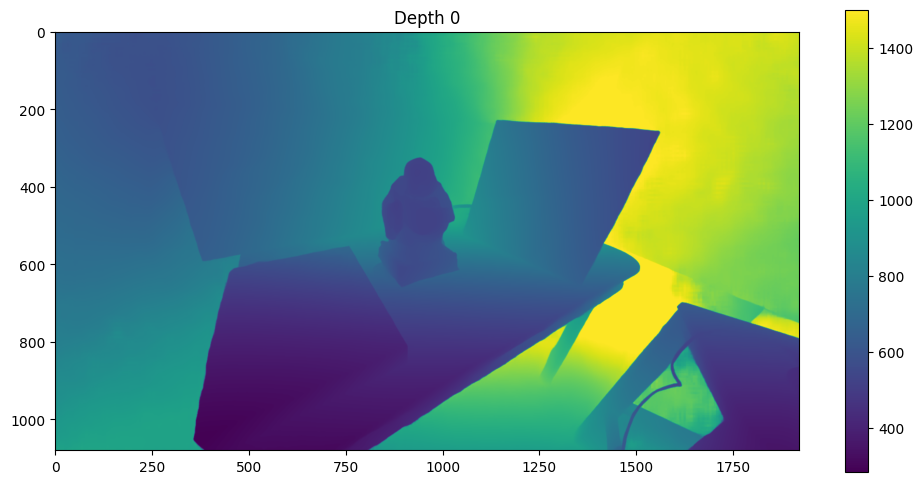

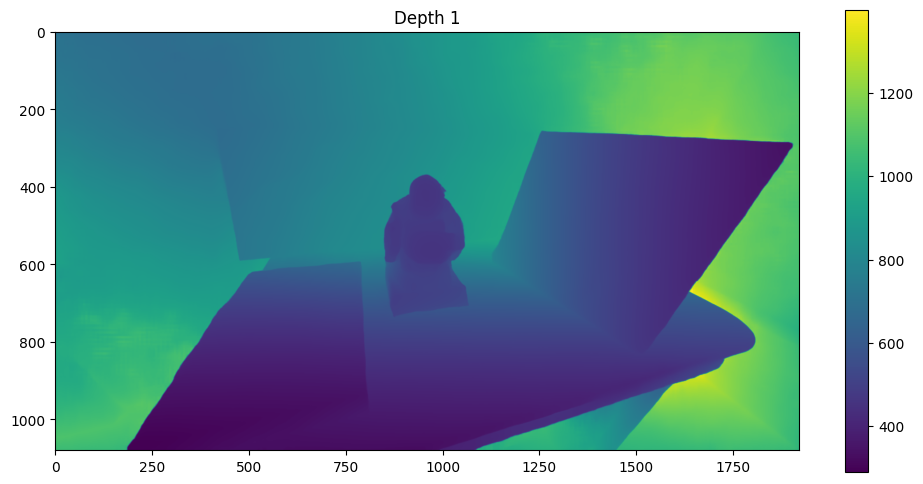

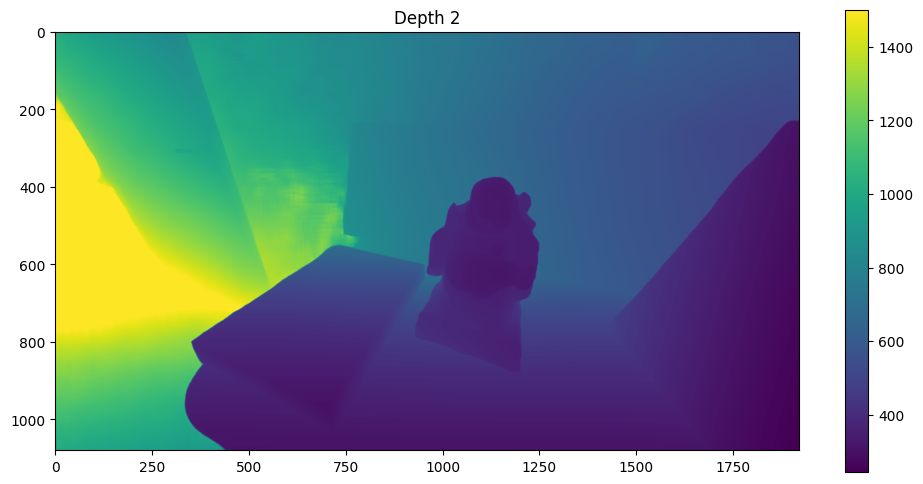

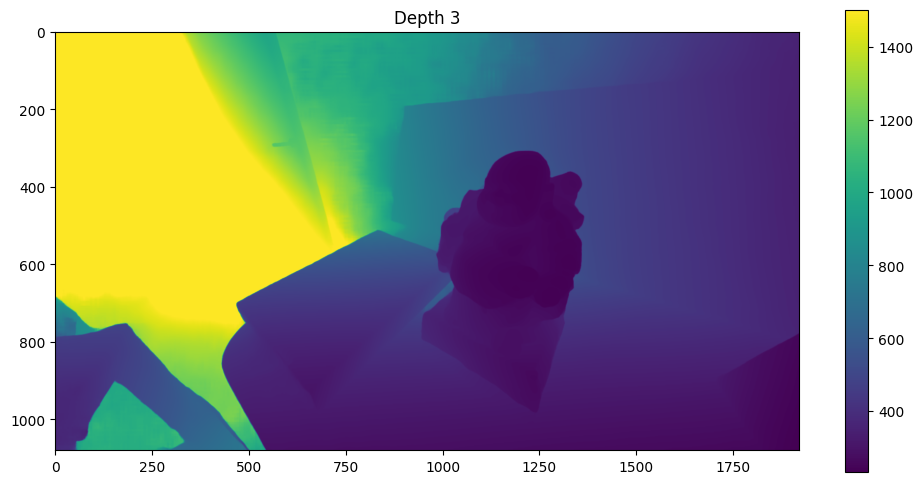

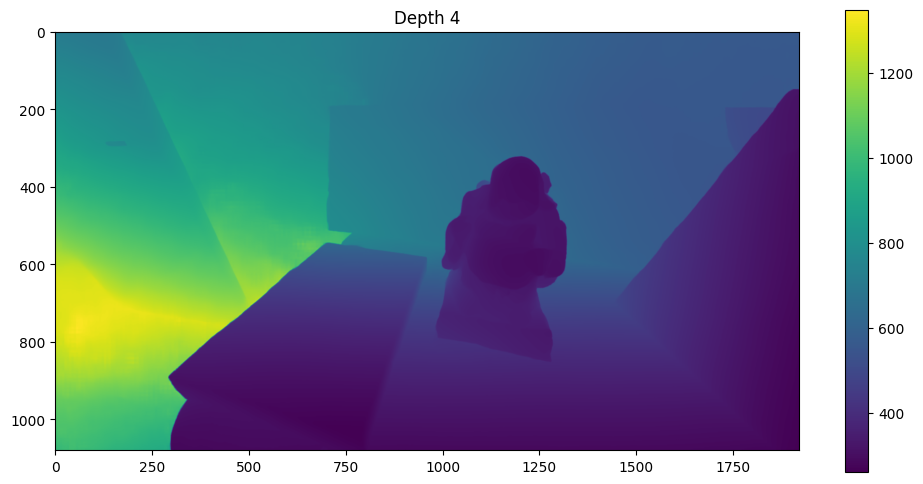

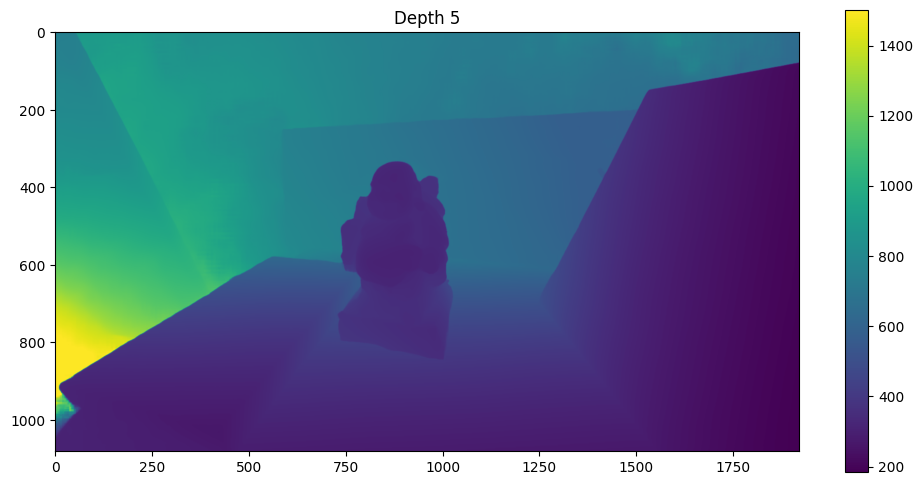

In [17]:
depths_clipped = []
for i, depth in enumerate(depths):
    depth2 = depth.copy()
    clip = 1500
    depth2[depth2 > clip] = clip 
    depths_clipped.append(depth2)
    plt.figure(figsize=(12, 6))
    plt.imshow(depth2)
    plt.colorbar()
    plt.title(f"Depth {i}")
    plt.show()

In [ ]:
# depths_path = "../datasets/budha_board/depths/depths.pkl"
# depths_dict = {
#     "depths": depths,
#     "depths_clipped": depths_clipped
# }
# with open(depths_path, "wb") as f:
#     pickle.dump(depths_dict, f)
# print(f"Depths guardadas en {depths_path}")

Depths guardadas en ../datasets/budha_board/depths/depths.pkl


In [ ]:
path = "../datasets/budha_board/disparities/disparities.pkl"
with open(path, "wb") as f:
    pickle.dump(disparities, f)